## Chargement du dataset 

In [1]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 128
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2025-04-19 20:02:25.375012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745085745.481775    1379 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745085745.514198    1379 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745085745.749087    1379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745085745.749142    1379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745085745.749144    1379 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.


I0000 00:00:1745085780.972679    1379 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Structure du modèle

In [2]:
import tensorflow as tf
from keras.saving import register_keras_serializable

# couche personnalisée pour gérer le pré-traitement des images 
@register_keras_serializable()   
class EfficientnetPreprocess(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EfficientnetPreprocess, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.keras.applications.efficientnet.preprocess_input(inputs)
        
# 1. Choisir un modèle préentraîné
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
#base_model.trainable = False  # Geler d'abord le modèle de base

# Dégeler les dernières couches du modèle de base
base_model.trainable = False

# Entrée du modèle
inputs = tf.keras.Input(shape=(224, 224, 3))
    
# Pipeline complet

# Data augmentation
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = tf.keras.layers.RandomContrast(0.2)(x)

# Prétraitement spécifique au modèle
x = EfficientnetPreprocess()(x)

 # Modèle de base
x = base_model(x, training=False)

# Couches de classification
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(nb_class, activation='softmax')(x)

# Construction finale
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_preprocess         │ (None, 224, 224, 3)    │             0 │
│ (EfficientnetPreprocess)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,413,886 (16.84 MB)

 Trainable params: 364,315 (1.39 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entrainement du modèle

Phase 1: Entraînement avec modèle de base gelé
Epoch 1/20


I0000 00:00:1745085854.008160    1746 cuda_dnn.cc:529] Loaded cuDNN version 90800


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.0686 - loss: 3.2900  
Epoch 1: val_accuracy improved from -inf to 0.28444, saving model to ../../src/models/EfficientNetB0_model_best.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - accuracy: 0.0687 - loss: 3.2895 - val_accuracy: 0.2844 - val_loss: 2.7005 - learning_rate: 1.0000e-04
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.1962 - loss: 2.7792  
Epoch 2: val_accuracy improved from 0.28444 to 0.35991, saving model to ../../src/models/EfficientNetB0_model_best.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 96s 283ms/step - accuracy: 0.1963 - loss: 2.7790 - val_accuracy: 0.3599 - val_loss: 2.3069 - learning_rate: 1.0000e-04
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.2649 - loss: 2.5301  
Epoch 3: val_accuracy improved from 0.35991 to 0.38676, saving model to ../../src/models/EfficientNetB0_model_best.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 96s 283ms/step - accuracy: 0.2649 - loss: 2.5300 - val_

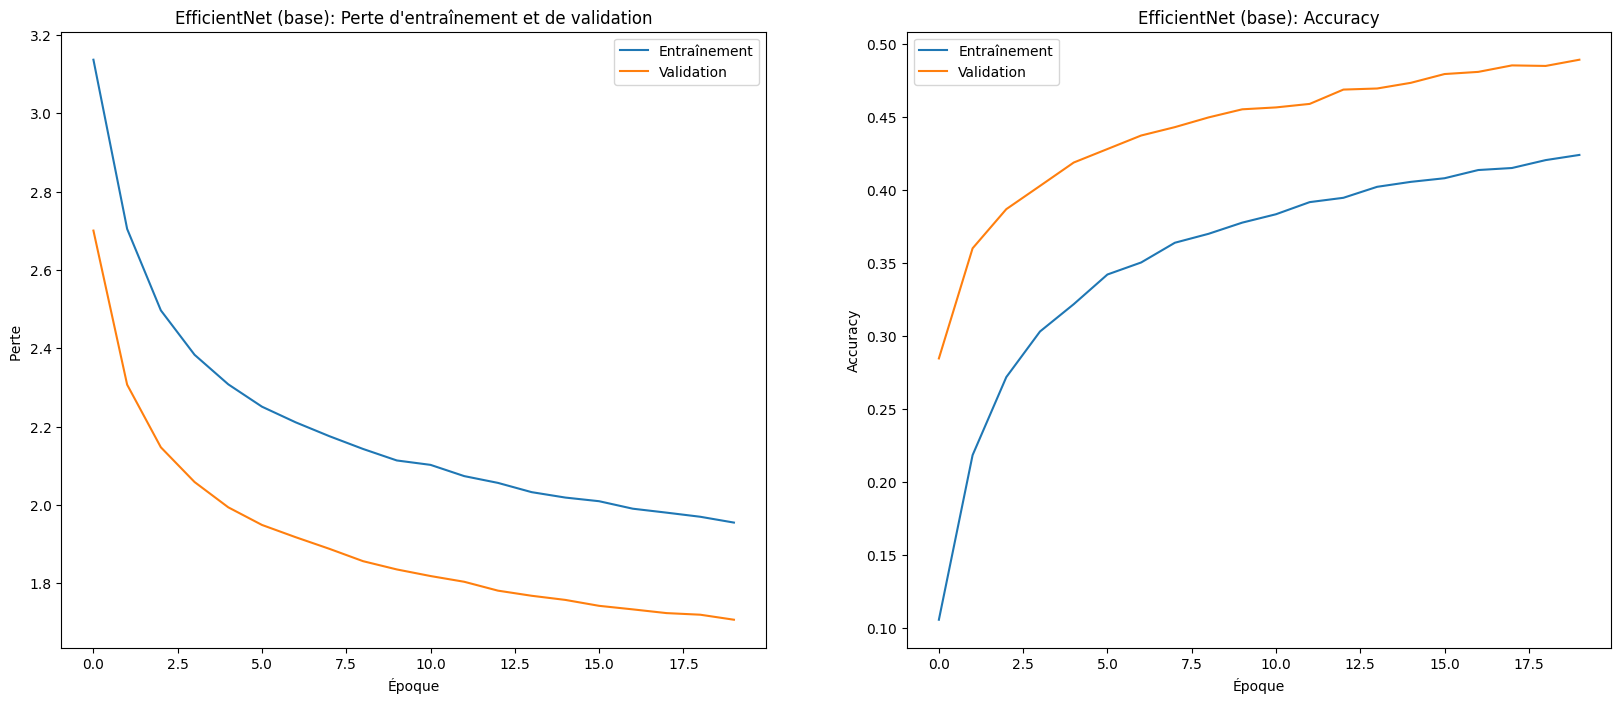

Analyse entraintement EfficientNet (fine tunning)


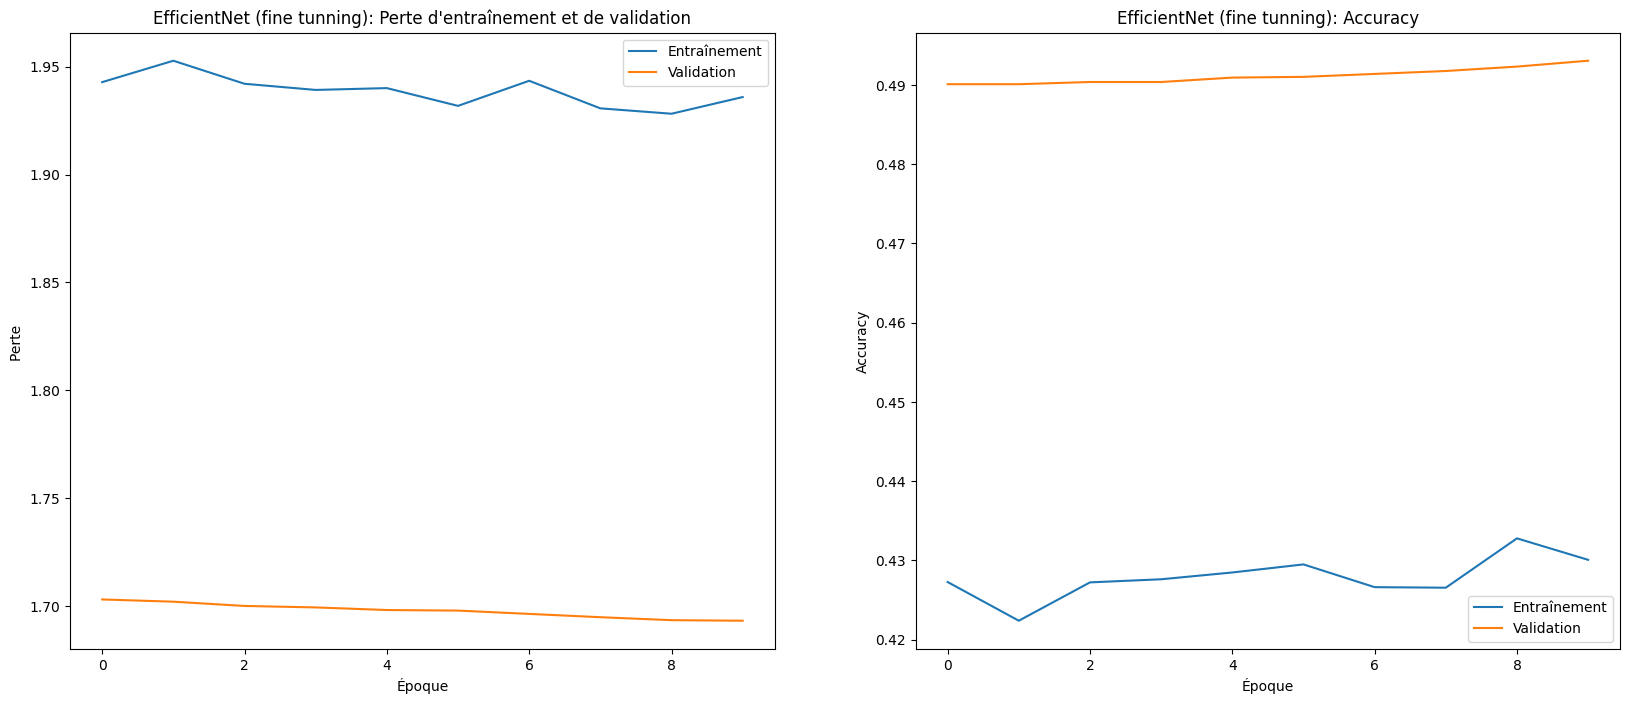

Analyse entraintement EfficientNet (fine tunning)


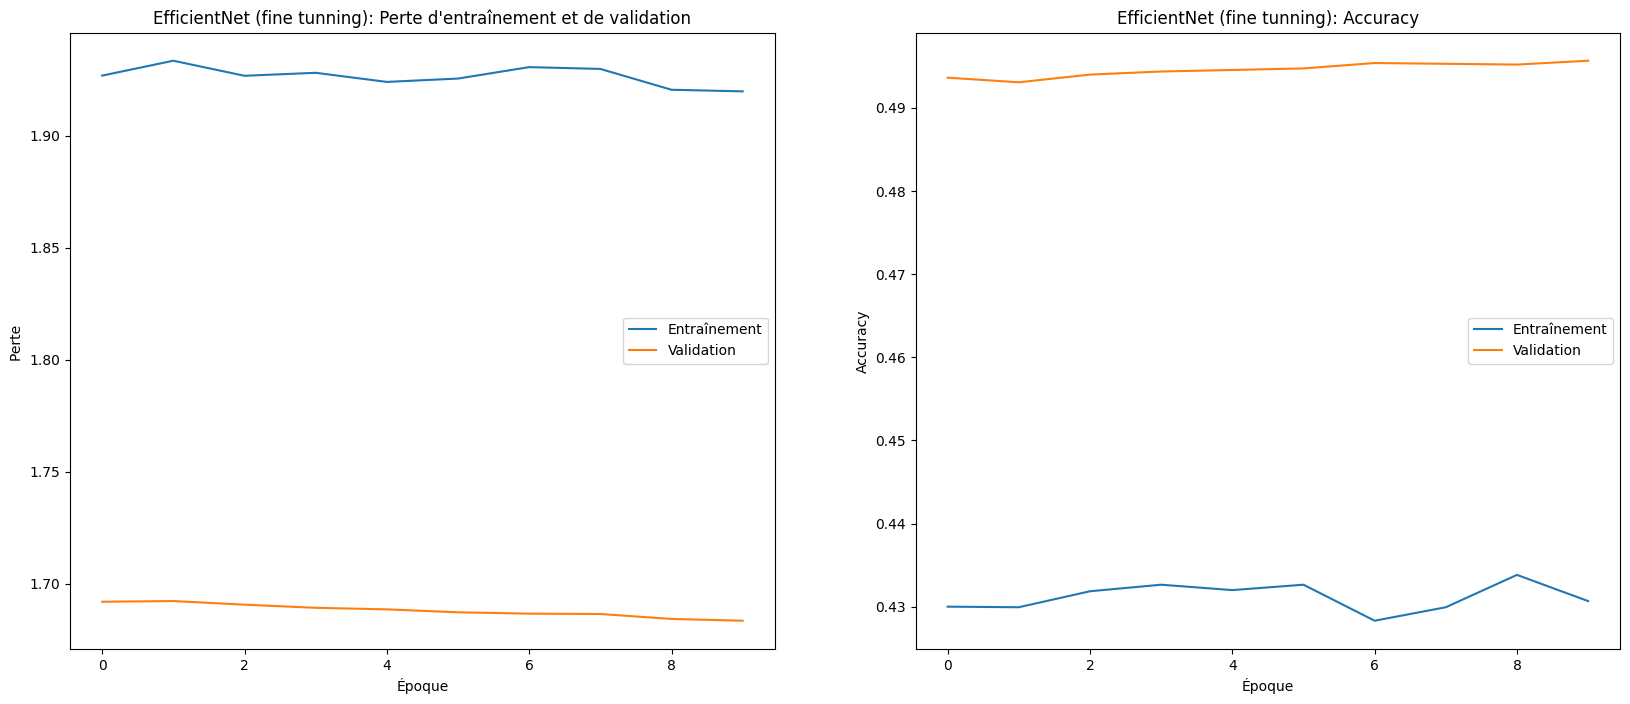

85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.4954 - loss: 1.6879
Précision de validation finale: 0.4956


In [3]:
# Définition des callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../../src/models/EfficientNetB0_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)


# Étape 2: Entraîner avec le modèle de base gelé
print("Phase 1: Entraînement avec modèle de base gelé")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  

model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=20,
                           callbacks=[lr_reducer, early_stopping, checkpoint])  


# Étape 3: Fine-tuning - dégeler partiellement le modèle de base
print("Phase 2: Fine-tuning")

# Fonction pour dégeler un bloc spécifique
def unfreeze_block(block_prefix):
    for layer in base_model.layers:
        if layer.name.startswith(block_prefix):
            layer.trainable = True

# Fonction pour recompiler et entraîner après chaque dégel
def fine_tune_block(block_prefix, epochs=10):
    print(f"🔓 Déblocage du bloc : {block_prefix}")
    unfreeze_block(block_prefix)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Plus petit LR en fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner avec fine-tuning
    return model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, lr_reducer, checkpoint]
    )

# 4. Fine-tuning progressif
history_phase2 = fine_tune_block("block7_")
history_phase3 = fine_tune_block("block6_")

# Sauvegarde du modèle final
model.save('../../src/models/EfficientNetB0_model_final.keras')

# Analyse de l'entainement
print("Analyse entraintement")
display_results(model_history, "EfficientNet (base)")

# Analyse de l'entainement
print("Analyse entraintement EfficientNet (fine tunning)")
display_results(history_phase2, "EfficientNet (fine tunning)")

# Analyse de l'entainement
print("Analyse entraintement EfficientNet (fine tunning)")
display_results(history_phase3, "EfficientNet (fine tunning)")

# Évaluation finale
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")



## Analyse de la performance par classe

In [4]:
# Chargement du model
model_loaded = tf.keras.models.load_model('../../src/models/EfficientNetB0_model_final.keras')

# Check
model_loaded.summary()

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 1.9999999494757503e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Could not locate class 'EfficientnetPreprocess'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'EfficientnetPreprocess', 'config': {'name': 'efficientnet_preprocess', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139719758121968}}, 'registered_name': 'EfficientnetPreprocess', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'efficientnet_preprocess', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['random_contrast', 0, 0]}}], 'kwargs': {}}]}

In [8]:
### ANALYSE DE LA PERFORMACE ###

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model_loaded.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()


NameError: Exception encountered when calling Lambda.call().

[1mname 'tf' is not defined[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • mask=None
  • training=False